# Машинное обучение 2021, часть 1, семинар 11. Ансамбли в машинном обучении

## Картинки про композиции

![](https://i.ibb.co/Wsf0s0m/bagging.jpg)

![](https://i.ibb.co/k16BL9v/boosting.jpg)

![](https://i.ibb.co/r5VPDd8/stacking.jpg)

## Беггинг на практике

Попробуем на практике пощупать разложение ошибки на смещение и разброс и посмотрим, как с этим помогает беггинг.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

Как это обычно бывает, для начала сгенрируем данные:

In [2]:
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

Т.к. для понимания ошибок нужно обучать алгоритмы на разных выборках, научимся генерировать одну:

In [3]:
def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y

In [4]:
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

In [5]:
X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging (Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


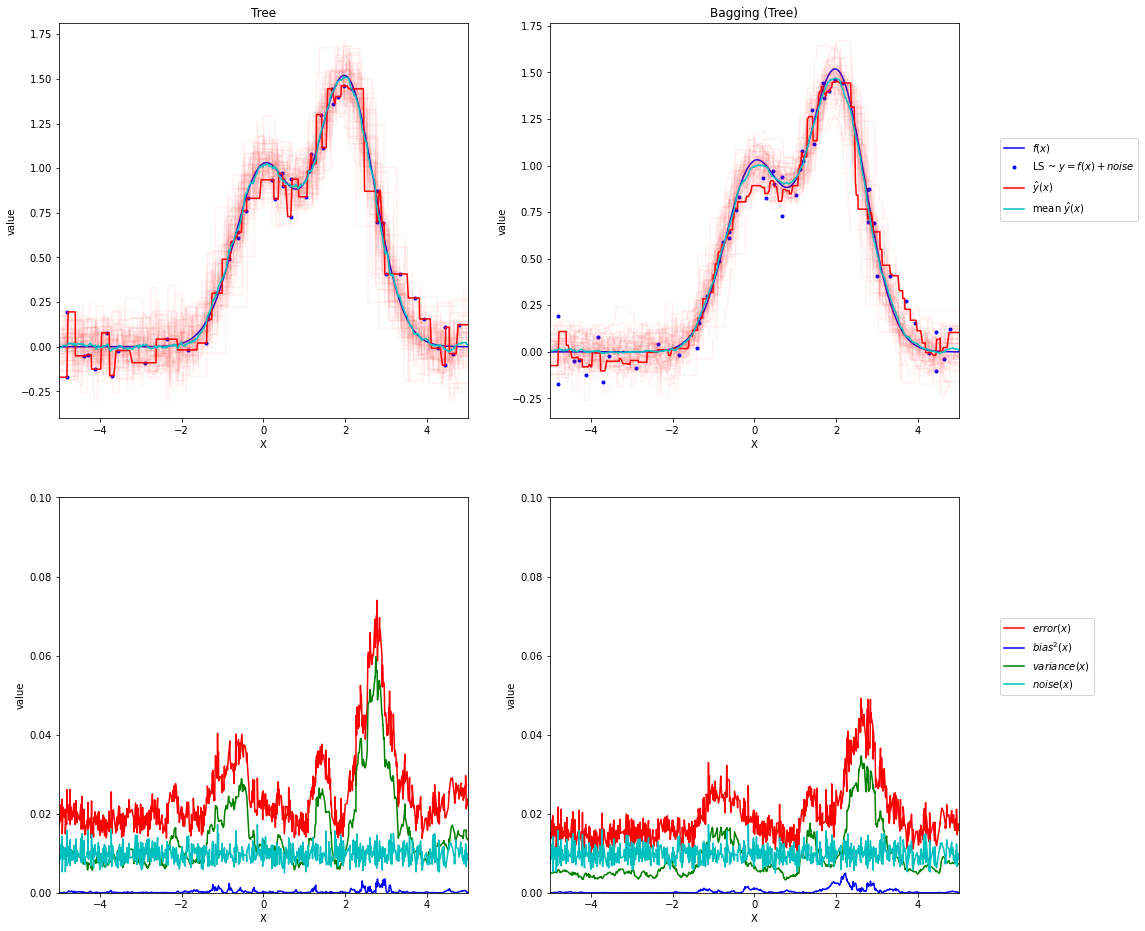

In [6]:
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging (Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)

plt.figure(figsize=(20, 16))

for n, (name, estimator) in enumerate(estimators):
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")
    plt.xlabel('X')
    plt.ylabel('value')

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label=r"mean $\^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")
    plt.xlabel('X')
    plt.ylabel('value')

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

**Задание 1 (0.5 балла)**. Аналогичным образом происследуйте bias-variance decomposition для метода ближайших соседей и линейной регрессии. У какого метода меньше смещение? У какого метода меньше разброс? Как вы думаете, почему так?

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

KNN: 0.0210 (error) = 0.0028 (bias^2)  + 0.0082 (var) + 0.0098 (noise)
Linear Regression: 0.0349 (error) = 0.0198 (bias^2)  + 0.0051 (var) + 0.0098 (noise)


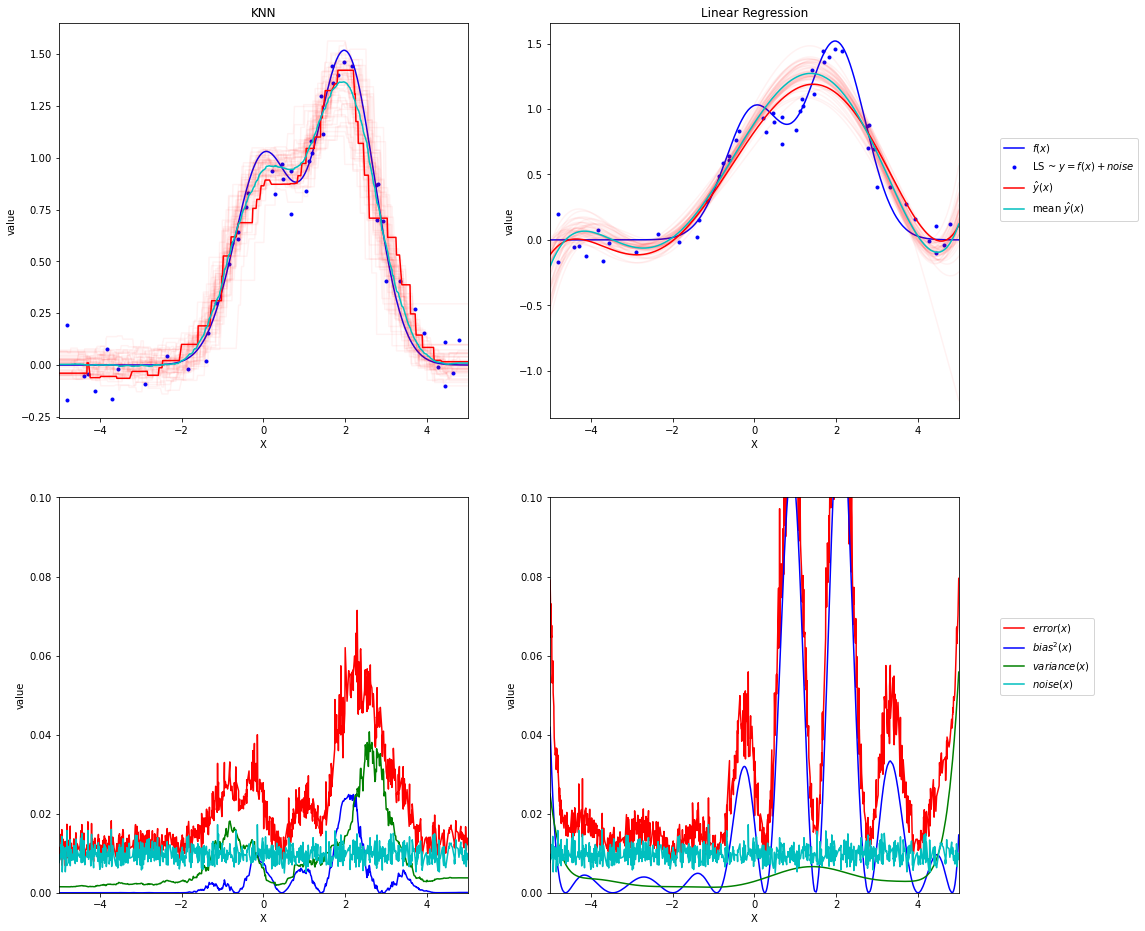

In [63]:
estimators = [("KNN", KNeighborsRegressor()),
              ("Linear Regression", LinearRegression())]

n_estimators = len(estimators)

plt.figure(figsize=(20, 16))
    
for n, (name, estimator) in enumerate(estimators):
    y_predict = np.zeros((n_test, n_repeat))
        
    for i in range(n_repeat):
        if name == "Linear Regression":
            estimator.fit(np.hstack((X_train[i], X_train[i]**2, X_train[i]**3, 
                                     X_train[i]**4, X_train[i]**5)), y_train[i])
            y_predict[:, i] = estimator.predict(np.hstack((X_test, X_test**2, X_test**3, 
                                                           X_test**4, X_test**5)))
        else:
            estimator.fit(X_train[i], y_train[i])
            y_predict[:, i] = estimator.predict(X_test)

    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")
    plt.xlabel('X')
    plt.ylabel('value')

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label=r"mean $\^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")
    plt.xlabel('X')
    plt.ylabel('value')

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

Видно, что смещение сильно больше у лин регрессии, а вот разброс как раз таки больше у knn. У knn больше разброс, потому что он сильнее подстраивается под обучающую выборку, если мы увеличим кол-во полиномиальных фичей у лин рег, то разброс у неё должен стать больше, т.к. она ещё сильнее переобучится на трейне. 

А ошибка на смещении такая большая у лин регресиии, т.к. мы думаем, что можем описать наши данные уравнением 4й степени, что в действительно куда хуже описывает данные чем метрические предположения knn о том, что если для точки рядом есть известные значения, то скорее всего у неё тоже будет примерно такое же значение.

**Задание 2 (0.5 балла)**. Аналогичным образом происследуйте зависимость разных компонент ошибок от параметра `max_depth` в дереве. Для этого на одной картинке нарисуйте несколько графиков значения bias от X. Аналогично поступите с variance. Выберите 5-10 показательных значений `max_depth`. Также постройте графики зависимости итоговых bias и variance от параметра `max_depth`. Проанализируйте полученные результаты. Как меняется bias и variance в зависимости от `max_depth` и почему?

Tree md2: 0.0565 (error) = 0.0264 (bias^2)  + 0.0198 (var) + 0.0098 (noise)
Tree md4: 0.0297 (error) = 0.0030 (bias^2)  + 0.0167 (var) + 0.0098 (noise)
Tree md5: 0.0250 (error) = 0.0008 (bias^2)  + 0.0142 (var) + 0.0098 (noise)
Tree md6: 0.0246 (error) = 0.0004 (bias^2)  + 0.0142 (var) + 0.0098 (noise)
Tree md7: 0.0251 (error) = 0.0003 (bias^2)  + 0.0148 (var) + 0.0098 (noise)
Tree md8: 0.0254 (error) = 0.0003 (bias^2)  + 0.0151 (var) + 0.0098 (noise)
Tree md10: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Tree md15: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Tree md20: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Tree md50: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)


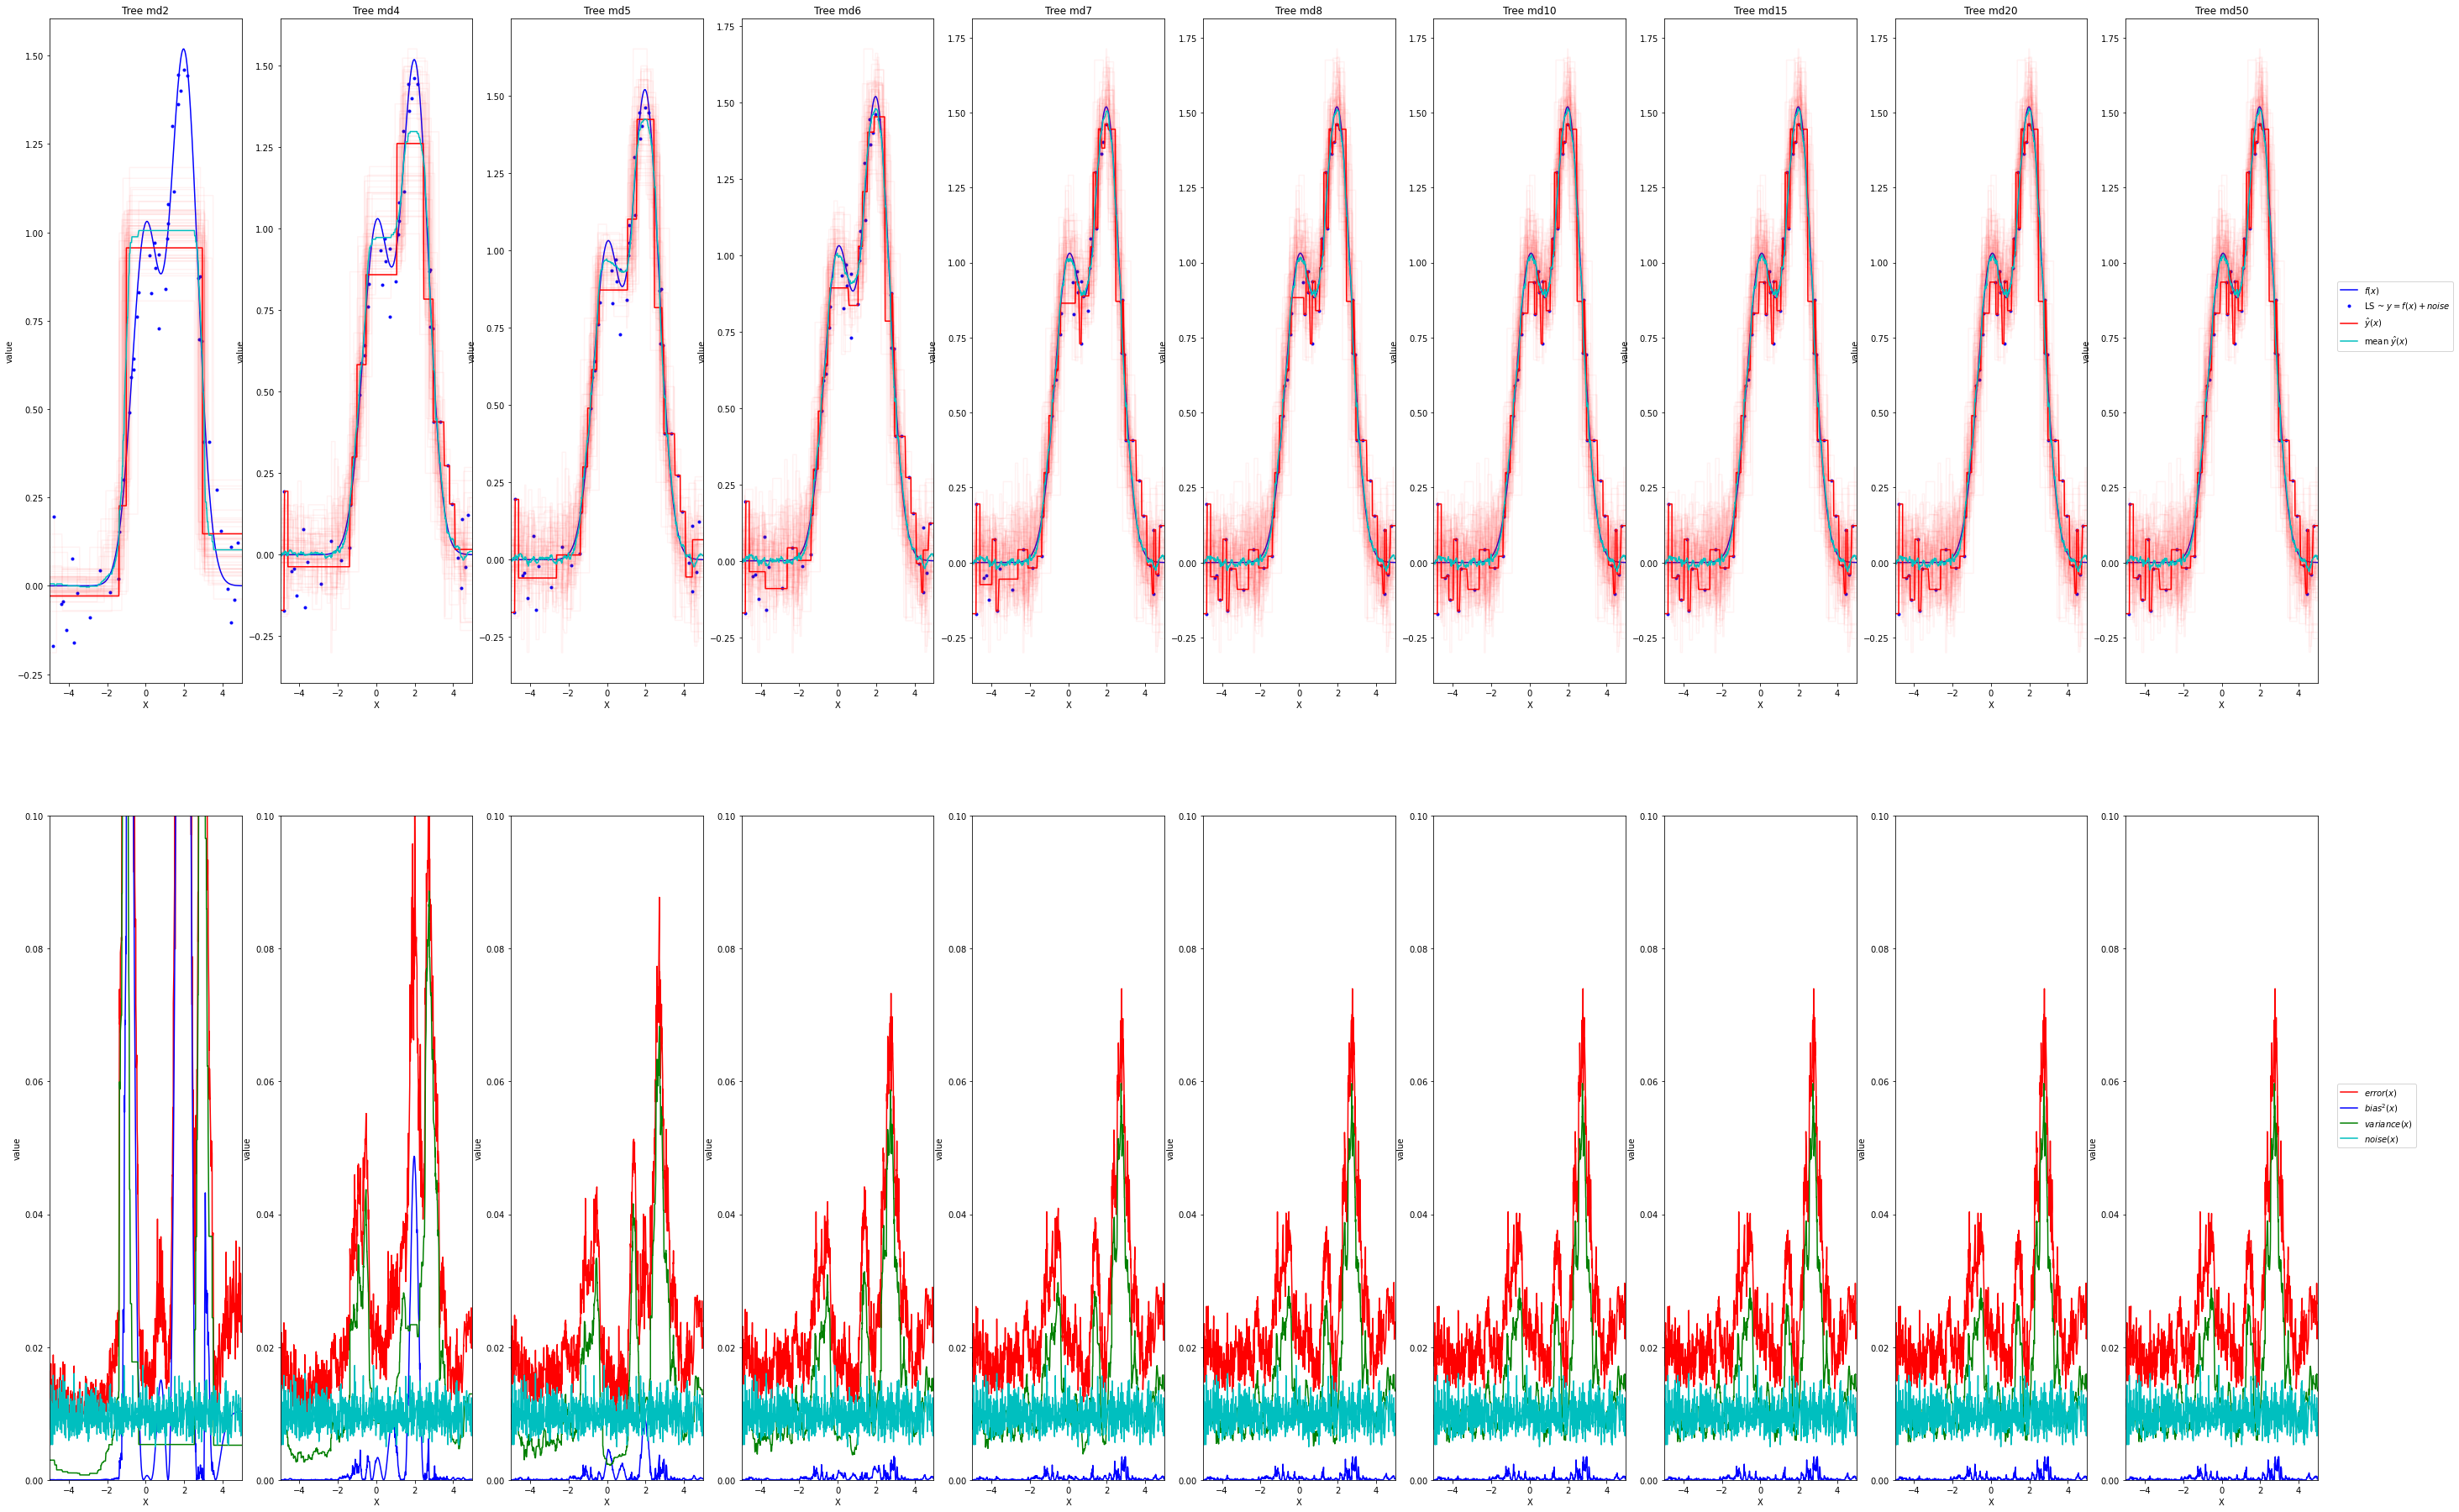

In [71]:
estimators = [("Tree md2", DecisionTreeRegressor(max_depth = 2)),
              ("Tree md4", DecisionTreeRegressor(max_depth = 4)),
              ("Tree md5", DecisionTreeRegressor(max_depth = 5)),
              ("Tree md6", DecisionTreeRegressor(max_depth = 6)),
              ("Tree md7", DecisionTreeRegressor(max_depth = 7)),
              ("Tree md8", DecisionTreeRegressor(max_depth = 8)),
              ("Tree md10", DecisionTreeRegressor(max_depth = 10)),
              ("Tree md15", DecisionTreeRegressor(max_depth = 15)),
              ("Tree md20", DecisionTreeRegressor(max_depth = 20)),
              ("Tree md50", DecisionTreeRegressor(max_depth = 50))]

n_estimators = len(estimators)

plt.figure(figsize=(60, 32))
    
for n, (name, estimator) in enumerate(estimators):
    y_predict = np.zeros((n_test, n_repeat))
        
    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")
    plt.xlabel('X')
    plt.ylabel('value')

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label=r"mean $\^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")
    plt.xlabel('X')
    plt.ylabel('value')

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

Так, глубина 2, это 4 листа, модель просто недоуобучается, а при глубине 10 и более у нас уже 1024+ листа, то есть модель максимально подстроилась под данные и там даже можно уже не смотреть что и как. Осталось разобраться что у нас между этими значениями происходит.

Впринципе, я бы пересказал ответ с прошлого задания, что изменения разброса показывают насколько качественно мы обучили алгоритм (переобучили/недообучили/ходим около оптимума для нашей модели). А смещение показывает насколько наша модель вообще адекватно подходит к заданию, и видно, что она может описывать функцию f достаточно неплохо уже после глубины дерева 5.

## Extra Trees

Не только случайным лесом едины! Если случайности в случайном лесу вам недостаточно, ещё большая случайность используется в методе под названием Extra Trees. 

Проще всего различия между ними, обычными деревьями и случайным лесом показать в следующей табличке:
![](https://i.stack.imgur.com/Q18mk.png)

Каковы же преимущества Extra Trees перед Random Forest? Кажется, какие-то они слишком уж случайные :)

Оказывается, что преимущества два:
* Extra Trees работают значительно быстрее (что неудивительно, учитывая метод их построения)
* Extra Trees лучше ведут себя при наличии большого количества нерелевантных признаков

![](https://www.thekerneltrip.com/images/rf_vs_et.png)

Эксперименты, подтверждающие второй пункт, вам и предстоит повторить!

**Задание 3 (1 балл)**. Постройте график, аналогичный данному. Для этого:
* научитесь генерировать случайную выборку с линейной зависимостью от конечного и всегда одинакового числа признаков, при этом с возможностью нагенерировать сколько угодно шумных
* переберите количество признаков, для каждого количества несколько раз сгенерируйте такую случайную выборку
* на каждой такой выборке обучите [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) и [`ExtraTreesRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)
* изобразите на графике их ошибку и стандартное отклонение

Предположите, почему же Extra Trees лучше работают при наличии лишних признаков, чем Random Forest?

In [85]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [74]:
def f(X):
    return 20 * X[0] + 17 * X[1] + 13 * X[2]

def generate(n_features = 3, noise = 0.1):
    # n_features have to be >= 3
    X = np.random.rand(n_features) * 10 - 5

    y = f(X) + np.random.normal(0.0, noise)

    return X, y

In [81]:
n_features = np.array([3, 4, 5, 7, 10, 15, 20, 40, 60, 80, 100])
n_train = 2000
n_test = 500

errors_ex_tr_mean = []
errors_ex_tr_sd = []
errors_rf_mean = []
errors_rf_sd = []

for i in n_features:
    errors_ex_tr = []
    errors_rf = []
    
    for __ in range(5):
        X_train = []
        y_train = []
        X_test = []
        y_test = []
    
        for _ in range(n_train):
            X, y = generate(n_features=i)
            X_train.append(X)
            y_train.append(y)

        for _ in range(n_test):
            X, y = generate(n_features=i)
            X_test.append(X)
            y_test.append(y)
    
        ex_tr = ExtraTreesRegressor(n_estimators=100, random_state=32).fit(X_train, y_train)
        rf = RandomForestRegressor(n_estimators=100, random_state=32).fit(X_train, y_train)
        errors_ex_tr.append(mean_squared_error(y_test, ex_tr.predict(X_test)))
        errors_rf.append(mean_squared_error(y_test, rf.predict(X_test)))  
        
    errors_ex_tr_mean.append(np.mean(np.array(errors_ex_tr)))
    errors_ex_tr_sd.append(np.std(np.array(errors_ex_tr)))
    errors_rf_mean.append(np.mean(np.array(errors_rf)))
    errors_rf_sd.append(np.std(np.array(errors_rf)))

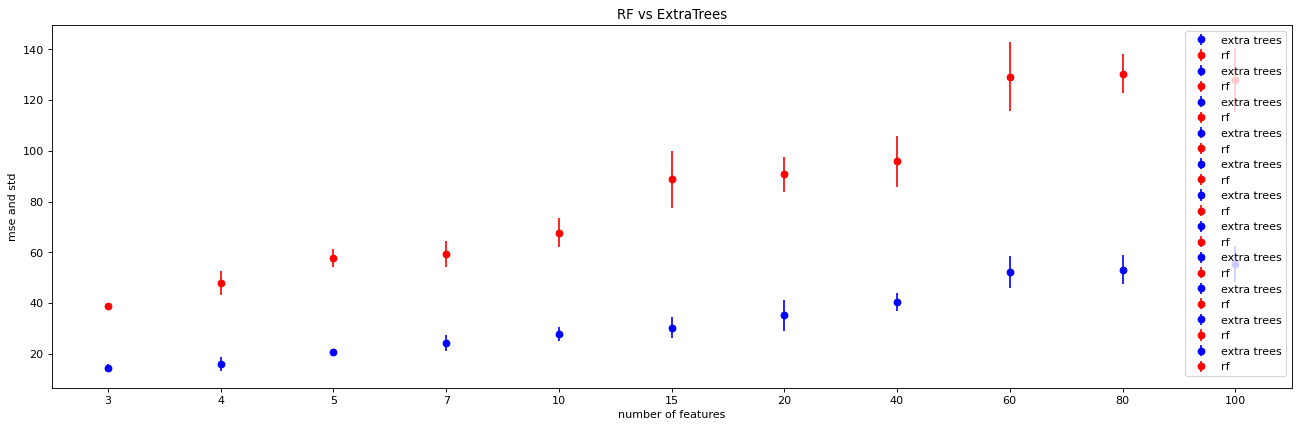

In [93]:
# errors_ex_tr_mean = []
# errors_ex_tr_sd = []
# errors_rf_mean = []
# errors_rf_sd = []

fig = figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')

ticks = list(range(len(n_features)))
plt.xticks(ticks, n_features)

for i in range(len(n_features)):
    y = errors_ex_tr_mean[i]
    e = errors_ex_tr_sd[i]
    plt.errorbar(i, y, e, linestyle='None', marker='o', color='blue', label='extra trees')
    y = errors_rf_mean[i]
    e = errors_rf_sd[i]
    plt.errorbar(i, y, e, linestyle='None', marker='o', color='red', label='rf')

plt.xlabel('number of features')
plt.ylabel('mse and std')
plt.title('RF vs ExtraTrees')

plt.legend()
plt.show()

Ну теперь я точно хочу попробовать это на кагле :) 

ExtraTr уменьшает разброс путём небольшого увеличения смещения. Если смотреть на оба алгоритма, то т.к. они берут выборки с помощью бутстрэпа (ниже исправлю, нет у ExtraTr бустрапа), строят деревья и усредняют результат, то очевидно, увеличивая количество бесполезных фич, количество глупых деревьев в этих ансамблях тоже будет расти, а следовательно всё больше и больше ошибка будет проникать в усреднённый результат. Но как видно на графике сверху, Random Forest подвержен этому больше, почему? 

1. Точно! На твоей же фотке показано (нашёл её на stackoverflow и вспомнил семинар :) ), что бустрэп то у нас только у rf, а следовательно там получается больше глупых деревьев, чем у extra trees.

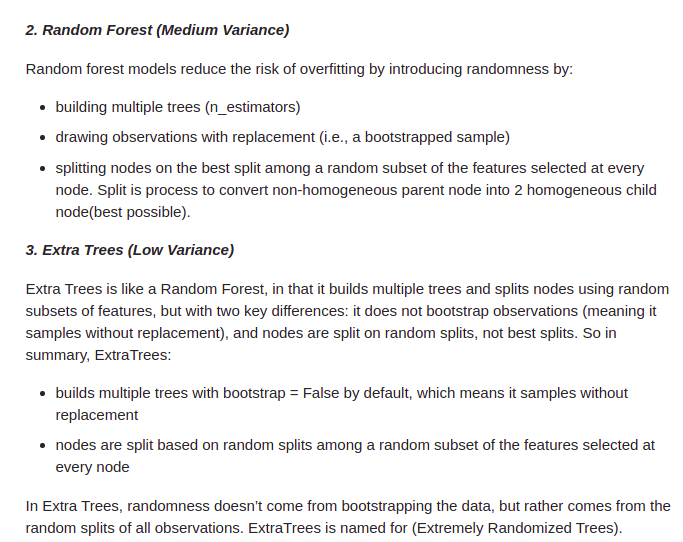

По сути я не знаю как именно нам помогает второй пункт (случайное разбиение) в улучшении vs RF, но как я понял оно нам нужно по-другой причине, чтобы в общем улучшить алгоритм добавлением большего рандома, чем в RF. Тем самым мы убрали рандом что сделали без бутстрапа, но добавили его больше за счёт разбиения по фичам случайным -> тем самым мы уменьшаем разброс (у нас не происходит общего переобучения глупого (т.к. нет бутстрапа, а он может сильно навредить при большом кол-ве бесполезных фич, которых у нас хватает)), но действительно увеличиваем смещение (т.к. алгоритм более случайный (из-за полнейшего рандома в вершинах дерева) -> меньше инфы выжимает из данных).

## Стекинг на практике

In [94]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

### Датасет

Наш сегодняшний датасет - это датасет бросков в игре дартс:

In [95]:
#!wget https://raw.githubusercontent.com/ben519/MLPB/master/Problems/Classify%20Dart%20Throwers/_Data/train.csv
train_df = pd.read_csv('train_1.csv')
train_df.head()

,ID,XCoord,YCoord,Competitor
0,111,0.943354,-0.184819,Bob
1,92,0.121557,-0.927656,Bob
2,20,0.818485,0.375437,Bob
3,75,0.867462,-0.159851,Sue
4,10,-0.817321,-0.373419,Kate


/home/elephant/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


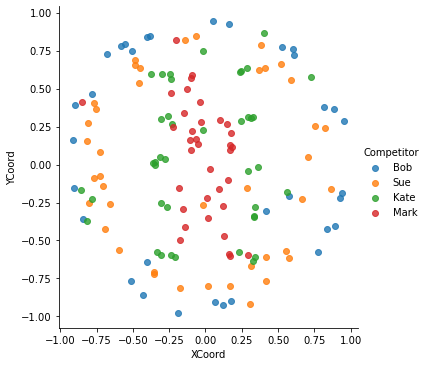

In [96]:
sns.lmplot('XCoord', 'YCoord', data=train_df, hue='Competitor', fit_reg=False)
plt.show()

In [97]:
#!wget https://raw.githubusercontent.com/ben519/MLPB/master/Problems/Classify%20Dart%20Throwers/_Data/test.csv
test_df = pd.read_csv('test.csv.1')
test_df.head()

,ID,XCoord,YCoord,Competitor
0,6,0.064729,0.356983,Mark
1,12,-0.766731,-0.255876,Sue
2,22,0.182282,-0.540976,Mark
3,34,-0.908910,0.223945,Bob
4,47,0.992230,-0.085550,Bob


/home/elephant/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


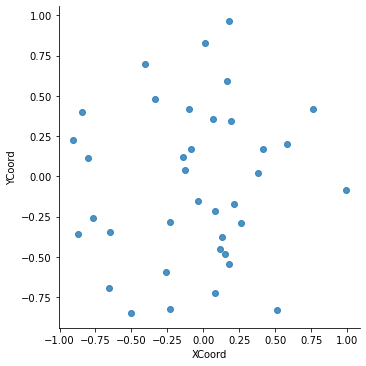

In [98]:
sns.lmplot('XCoord', 'YCoord', data=test_df, fit_reg=False)
plt.show()

Подготовим обучающую выборку в более привычном виде, а также подготовимся к визуализации разделяющей гиперплоскости:

In [99]:
X, y = train_df.values[:, 1:-1], train_df.values[:, -1:]

In [100]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

In [101]:
y_temp = []
for name in y:
    if name == 'Bob':
        y_temp.append(1)
    elif name == 'Mark':
        y_temp.append(2)
    elif name == 'Sue':
        y_temp.append(3)
    elif name == 'Kate':
        y_temp.append(4)
y = np.array(y_temp)

### Одиночные алгоритмы

Наш первый подопытный - kNN:

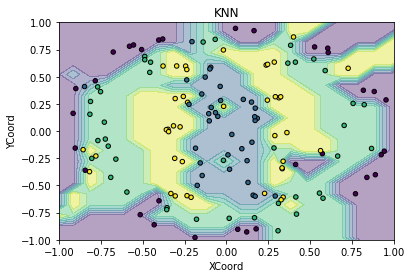

In [102]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X, y)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.title('KNN')
plt.xlabel('XCoord')
plt.ylabel('YCoord')
plt.show()

А второй - SVM:

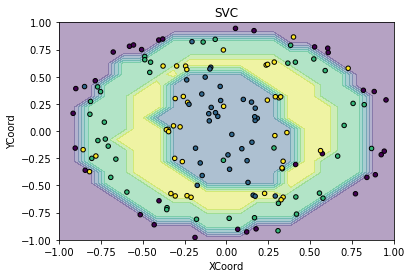

In [103]:
from sklearn.svm import SVC

clf = SVC(kernel='poly', degree=2)
clf.fit(X, y)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.title('SVC')
plt.xlabel('XCoord')
plt.ylabel('YCoord')
plt.show()

Когда у нас есть два базовых классификатора (каждый из которых, как видно, справляется с классификацией очень по-разному), можно попытаться выжать из их комбинации всё :)

### Рецепт хорошего стекинга

Самый лучший рецепт - это выполненный своими руками! ;) Поэтому, слушайте внимательно:

**Задание 1 (1 балл)**.
* Подберите оптимальные параметры для двух базовых классификаторов. Посчитайте для них accuracy.
* Разбейте train на 5 фолдов.
* Для каждого фолда из train обучите классификатор на остальных и в качестве мета-фичи объектов этого фолда запишите предсказания моделей
* Обучите модель на всём train и для каждого объекта из test вычислите мета-фичи
* Возьмите новый классификатор и обучите его на train с мета-фичами
* Предскажите метки на test и измерьте accuracy

Бонус: у кого с помощью стекинга этих двух моделей получится наилучший результат на test, получит дополнительные 0.5 балла :)

In [253]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from scipy.stats import loguniform
from sklearn.metrics import accuracy_score

In [212]:
X, y = train_df.values[:, 1:-1], train_df.values[:, -1:]
X_test, y_test = test_df.values[:, 1:-1], test_df.values[:, -1:]

y_temp = []
for name in y:
    if name == 'Bob':
        y_temp.append(1)
    elif name == 'Mark':
        y_temp.append(2)
    elif name == 'Sue':
        y_temp.append(3)
    elif name == 'Kate':
        y_temp.append(4)
y = np.array(y_temp)

y_temp = []
for name in y_test:
    if name == 'Bob':
        y_temp.append(1)
    elif name == 'Mark':
        y_temp.append(2)
    elif name == 'Sue':
        y_temp.append(3)
    elif name == 'Kate':
        y_temp.append(4)
y_test = np.array(y_temp)

In [213]:
X.shape

(150, 2)

In [214]:
X_test.shape

(37, 2)

In [191]:
X_my_train, X_my_test, y_my_train, y_my_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_my_train.shape)

(105, 2)


In [257]:
knn_parameters = {'n_neighbors':[1, 2, 3, 4, 5]}

clf1 = KNeighborsClassifier()

knn_grid = GridSearchCV(clf1, knn_parameters, verbose = 10, n_jobs=-1, cv=StratifiedKFold(),
                        scoring = 'accuracy')
knn_grid.fit(X_my_train, np.array(y_my_train).ravel())
knn_grid.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'n_neighbors': 1}

In [258]:
clf11 = KNeighborsClassifier(n_neighbors=5)
clf11.fit(X_my_train, np.array(y_my_train).ravel())
accuracy_score(y_my_test, clf11.predict(X_my_test))

0.6

In [194]:
svm_parameters = {'C':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0, 1e1, 1e2, 1e3, 1e4, 1e5]}

clf2 = SVC(kernel='poly', degree=2)

svm_grid = GridSearchCV(clf2, svm_parameters, verbose = 10, n_jobs=-1, cv=StratifiedKFold())
svm_grid.fit(X_my_train, np.array(y_my_train).ravel())
svm_grid.best_params_

Fitting 5 folds for each of 11 candidates, totalling 55 fits


/home/elephant/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.28571429 0.28571429 0.28571429 0.28571429 0.4               nan
 0.73333333 0.76190476 0.78095238 0.78095238 0.78095238]
  category=UserWarning


{'C': 1000.0}

In [195]:
clf22 = SVC(kernel='poly', degree=2, C = 1000)
clf22.fit(X_my_train, np.array(y_my_train).ravel())
accuracy_score(y_my_test, clf22.predict(X_my_test))

0.8222222222222222

In [283]:
meta = np.array([[0, 0]] * 150)
print(meta.shape)
for train, test in StratifiedKFold(n_splits=5, shuffle = True, random_state = 42).split(X, y):
    knn = KNeighborsClassifier(n_neighbors=1)
    svc = SVC(kernel='poly', degree=2, C = 1000)
    knn.fit(X[train], y[train])
    svc.fit(X[train], y[train])
    meta[test, 0] = knn.predict(X[test])
    meta[test, 1] = svc.predict(X[test])

(150, 2)


In [284]:
print(meta[-5:])
print(y[-5:])

[[3 3]
 [3 3]
 [4 1]
 [3 3]
 [3 3]]
[2 3 1 4 3]


In [285]:
X_meta = np.hstack((X, meta))
print(X_meta.shape)

(150, 4)


In [286]:
test_meta = np.array([[0, 0]] * 37)

knn = KNeighborsClassifier(n_neighbors=1)
svc = SVC(kernel='poly', degree=2, C = 1000)
knn.fit(X, meta[:, 0])
svc.fit(X, meta[:, 1])
test_meta[:, 0] = knn.predict(X_test)
test_meta[:, 1] = svc.predict(X_test)

In [287]:
X_test_meta = np.hstack((X_test, test_meta))
print(X_test_meta.shape)

(37, 4)


In [349]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [343]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_meta, y)
accuracy_score(y_test, log_reg.predict(X_test_meta))

0.8108108108108109

In [390]:
rf = RandomForestClassifier(n_estimators = 1000, max_depth = 5)
rf.fit(X_meta, y)
accuracy_score(y_test, rf.predict(X_test_meta))

0.8378378378378378

In [355]:
nb = GaussianNB()
nb.fit(X_meta, y)
accuracy_score(y_test, nb.predict(X_test_meta))

0.7837837837837838

In [327]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

In [320]:
X, y = train_df.values[:, 1:-1], train_df.values[:, -1:]
X_test, y_test = test_df.values[:, 1:-1], test_df.values[:, -1:]

y_temp = []
for name in y:
    if name == 'Bob':
        y_temp.append(1)
    elif name == 'Mark':
        y_temp.append(2)
    elif name == 'Sue':
        y_temp.append(3)
    elif name == 'Kate':
        y_temp.append(4)
y = np.array(y_temp)

y_temp = []
for name in y_test:
    if name == 'Bob':
        y_temp.append(1)
    elif name == 'Mark':
        y_temp.append(2)
    elif name == 'Sue':
        y_temp.append(3)
    elif name == 'Kate':
        y_temp.append(4)
y_test = np.array(y_temp)

In [347]:
estimators = [('knn', KNeighborsClassifier(n_neighbors=1)),
              ('svc', make_pipeline(SVC(kernel='poly', degree=2, C = 1000)))] 
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000))
accuracy_score(y_test, clf.fit(X, y).predict(X_test))

0.8648648648648649

мой лучший результат - 0.8378378378378378 (RF)

Вопросы на засыпку:
* почему мета-фичи для объектов из train нужно получать так странно? Почему бы не обучиться на всём train и не сделать после этого предсказания?
* как правильно делать кросс-валидацию? Нормально ли использовать те же фолды, что и при обучении мета-фичей или нет?